<a href="https://colab.research.google.com/github/YDxun/Hands-On-AI/blob/main/Demo_IML_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IML-ViT: Benchmarking Image Manipulation Localization by Vision Transformer**

This notebook provides a example of our training & inference pipeline of how to apply IML-ViT to image manipulation localization tasks.

We also provide a playground for you to try out IML-ViT on various images from the Internet through URLs.

[[Paper](https://arxiv.org/abs/2307.14863)][[Github](https://github.com/SunnyHaze/IML-ViT)]

### **1.Preparation**
Clone the official repo to this Colab space and install requirements.

In [ ]:
import os
if os.getcwd() != "/content/IML-ViT":
  !git clone https://github.com/SunnyHaze/IML-ViT
  os.chdir("IML-ViT")
!pip install -r requirements.txt
!pwd

fatal: destination path 'IML-ViT' already exists and is not an empty directory.
/content/IML-ViT


### **2.Load a toy Dataset**
- We defined two types of Dataset class
  - `json_dataset`, which get input image and correspoding groundtruth from a json file with protocol like this:
    ```
    [
        [
          "/Dataset/CASIAv1/Tp/image1.jpg",
          "/Dataset/CASIAv2/Gt/image1.jpg"
        ],
        [
          "/Dataset/CASIAv1/Tp/image2.jpg",
          "Negative"
        ],
        ......
    ]
    ```
    where "Negative" represent a totally black groundtruth that don't needs a path(all authentic)
  - `mani_dataset` which loads image and groundtruth pairs automaticlly from a directory having sub-directories named as `Tp` (for input images) and `Gt` |(for groundtruths). This class will use sorted `os.listdir()` function to generate the pairs.
- These datasets will do **zero-padding** automatically. Common augumentation method like ImageNet normalization will also be added.
- Both datasets can generate `edge_mask` when specify the `edge_width` parameter. Then, this dataset will return 3 objects (image, GT, edge mask) while only 2 objects when `edge_width=None`.
- For inference, returing the actual shape of the original image is crucial. You can set `if_return_shape=True` to get this value.

In [ ]:
# Pre-import and set for a clear ploting
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 60
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (24, 6)
from utils.datasets import mani_dataset # special Dataset class

In [ ]:
# here we use mani dataset as example
input_dir = "./images/sample_iml_dataset/"
dataset = mani_dataset(
  path = input_dir,
  edge_width=7, # specify the edge mask, other wise only return 2 objects
  if_return_shape=True
)
print(dataset)
print(f"Length of this dataset: {len(dataset)}")

Length of this dataset: 2


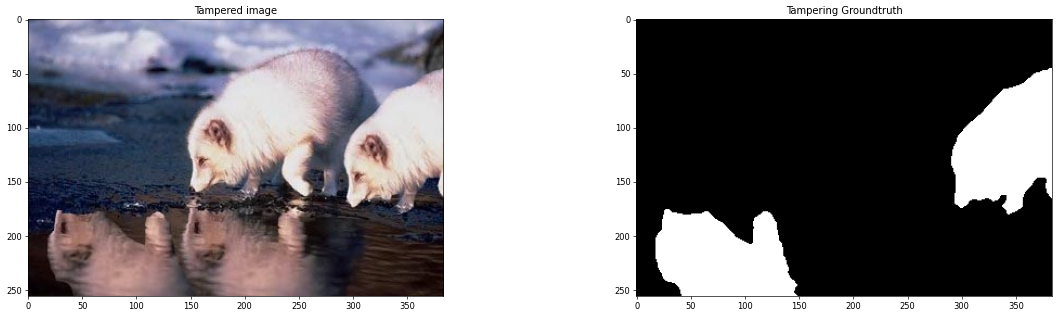

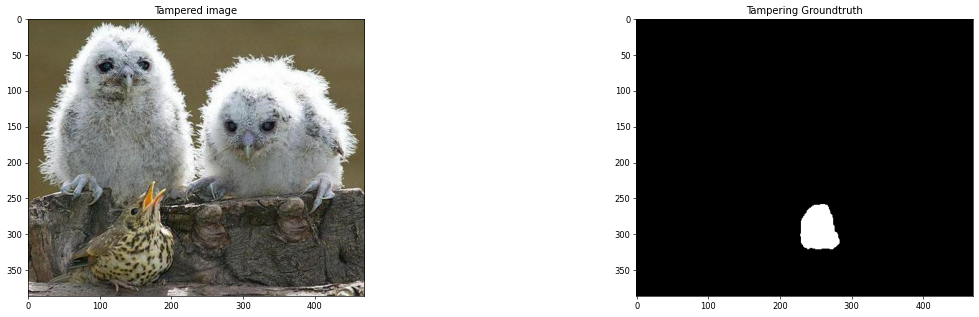

In [ ]:
# Visualize datas without any augmentation
for img, gt in zip(dataset.tp_path, dataset.gt_path):
  img = plt.imread(img)
  gt = plt.imread(gt)
  plt.subplot(1, 2, 1)
  plt.title("Tampered image")
  plt.imshow(img)
  plt.subplot(1, 2, 2)
  plt.title("Tampering Groundtruth")
  plt.imshow(gt, cmap="gray")
  plt.show()

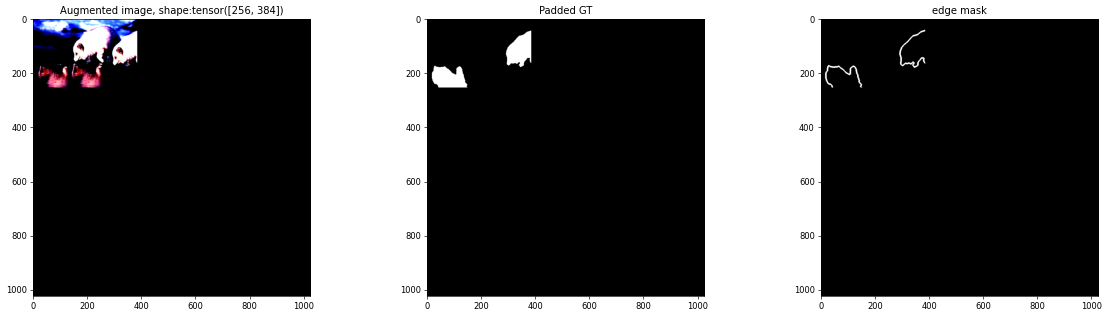

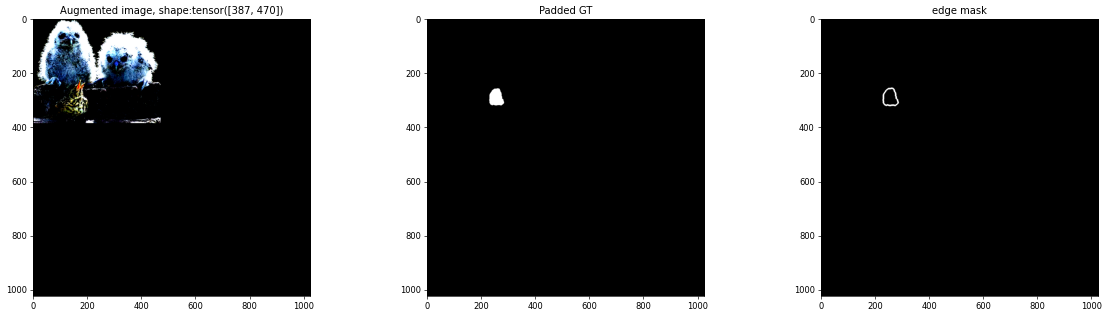

In [ ]:
# Visualize after build-in transform (zero-padding and augmentations)
for img, gt, edge_mask, shape in dataset:
  plt.subplot(1, 3, 1)
  img = img.permute(1, 2, 0) # CHW -> HWC
  plt.imshow(img)
  plt.title(f"Augmented image, shape:{shape}")
  plt.subplot(1, 3, 2)
  gt = gt.permute(1, 2, 0) # CHW -> HWC
  plt.imshow(gt, cmap='gray')
  plt.title("Padded GT")
  plt.subplot(1, 3, 3)
  edge_mask = edge_mask.permute(1, 2, 0) # CHW -> HWC
  plt.imshow(edge_mask, cmap='gray')
  plt.title("edge mask")
  plt.show()

### **3.Download the weights and init the IML-ViT model**

In [ ]:
# Download from google drive

# CASIAv2 checkpoint
!gdown https://drive.google.com/uc?id=1Rs9gsg6vZmzKOcwx4udB3-A0FwjfFenb

# CAT-Net protocol checkpoint
!gdown https://drive.google.com/uc?id=1jlXw97GkyBbY4u5-e_liuhahKSQWCAFu
!mv iml-vit_checkpoint*.pth checkpoints

Downloading...
From (original): https://drive.google.com/uc?id=1Rs9gsg6vZmzKOcwx4udB3-A0FwjfFenb
From (redirected): https://drive.google.com/uc?id=1Rs9gsg6vZmzKOcwx4udB3-A0FwjfFenb&confirm=t&uuid=033b9795-3c20-44ee-98f8-f08e57b86234
To: /content/IML-ViT/iml-vit_checkpoint_casiav2_20231014.pth
100% 367M/367M [00:03<00:00, 93.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1jlXw97GkyBbY4u5-e_liuhahKSQWCAFu
From (redirected): https://drive.google.com/uc?id=1jlXw97GkyBbY4u5-e_liuhahKSQWCAFu&confirm=t&uuid=4b940879-c92f-462c-95b1-79ada4848711
To: /content/IML-ViT/iml-vit_checkpoint_trufor_20231104.pth
100% 367M/367M [00:02<00:00, 151MB/s]


In [ ]:
import torch
from iml_vit_model import iml_vit_model

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # if out of memory, then uncommenting this line

print("Device:", device)

# CASIAv2 trained checkpoint
ckpt_path = "./checkpoints/iml-vit_checkpoint_casiav2_20231014.pth"

# CAT-Net traind checkpoint
# ckpt_path = "./checkpoints/iml-vit_checkpoint_trufor_20231104.pth"

model = iml_vit_model()

model.load_state_dict(
  torch.load(ckpt_path),
  strict = True
)
model = model.to(device)

Device: cuda


<ipython-input-7-39b38879a79b>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path),


### **4.Inference example**
This process require your GPU has at least 6GB of memory.
For colab without a GPU, it may takes **a minute**. Please wait patiently.

shape: tensor([256, 384])


Predict Loss:0.02067143220739276, including edge loss: 0.018557060798395364


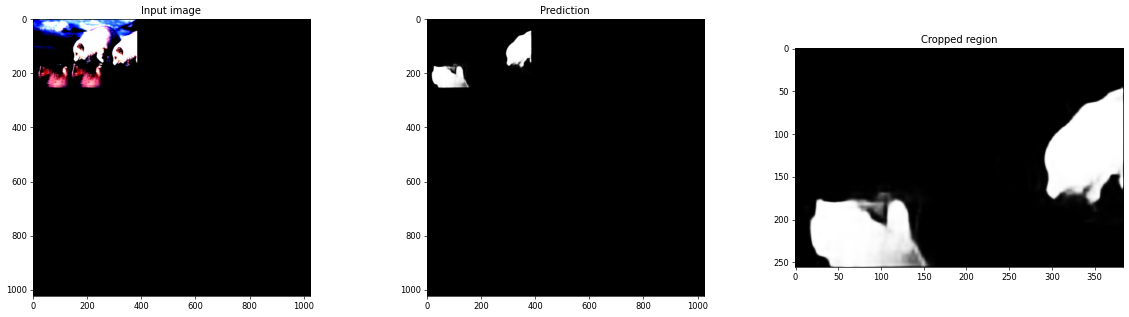

shape: tensor([387, 470])


Predict Loss:0.008787999423723741, including edge loss: 0.007806043435798493


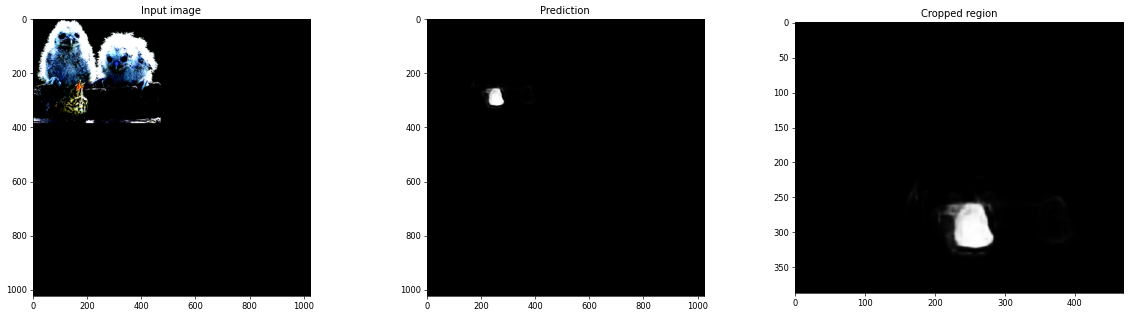

Done!


In [ ]:
results = []
model.eval()
with torch.no_grad():
  for img, gt, edge_mask, shape in dataset:    # Inference don't need edge mask.
    img, gt, edge_mask = img.to(device), gt.to(device), edge_mask.to(device)
    # Since no Dataloader, manually create a Batch with size==1
    img = img.unsqueeze(0) # CHW -> 1CHW
    gt = gt.unsqueeze(0)
    edge_mask = edge_mask.unsqueeze(0)
    print("shape:", shape)
    # inference
    predict_loss, mask_pred, edge_loss = model(img, gt, edge_mask)
    print(f"Predict Loss:{predict_loss}, including edge loss: {edge_loss}")
    output = mask_pred

    # visualize
    plt.subplot(1, 3, 1)
    plt.title("Input image")
    plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(output.cpu().numpy()[0][0], cmap='gray')


    # Cut the origin area from padded image
    output = output[0, :, 0:shape[0], 0:shape[1]].permute(1, 2, 0).cpu().numpy()
    results.append(output)
    plt.subplot(1, 3, 3)
    plt.title("Cropped region")
    plt.imshow(output, cmap='gray')
    plt.show()
print("Done!")

### **5.Thresholding & visualizing**
We use 0.5 to threshold the prediction map.

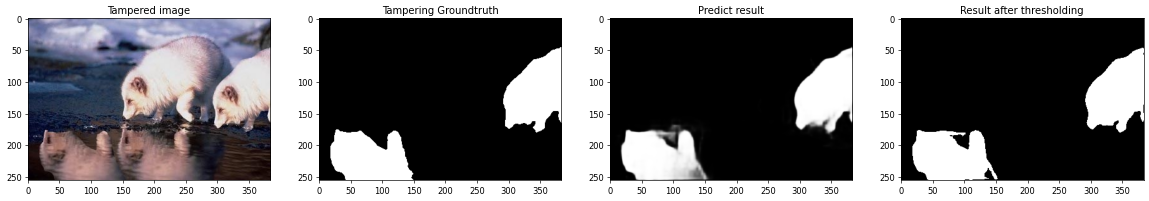

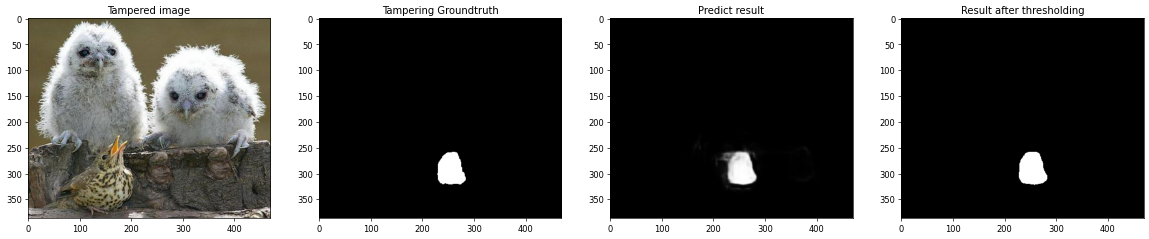

In [ ]:
# Visualize the results:
for img, gt, res in zip(dataset.tp_path, dataset.gt_path, results):
  img = plt.imread(img)
  gt = plt.imread(gt)
  plt.subplot(1, 4, 1)
  plt.title("Tampered image")
  plt.imshow(img)
  plt.subplot(1, 4, 2)
  plt.title("Tampering Groundtruth")
  plt.imshow(gt, cmap="gray")
  plt.subplot(1, 4, 3)
  plt.title("Predict result")
  plt.imshow(res, cmap="gray")
  plt.subplot(1, 4, 4)
  plt.title("Result after thresholding")
  plt.imshow(res > 0.5, cmap="gray")
  plt.show()

### **6.Test on web images**:
An example of how to inference a image from internet without a corresponding mask.


#### **Prepaer for functions**

In [ ]:
# define the transforms with Albumentation libarary
# Full references can be found at https://albumentations.ai/docs/api_reference/full_reference/

import albumentations as albu
from albumentations.pytorch import ToTensorV2

resize_trans = albu.LongestMaxSize(max_size = 1024) # Our maximum edge length is 1024.

padding_trans = albu.Compose([
  albu.PadIfNeeded(
    min_height=1024,
    min_width=1024,
    border_mode=0,
    value=0,
    position= 'top_left',
    mask_value=0),
  albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  albu.Crop(0, 0, 1024, 1024),
  ToTensorV2(transpose_mask=True)
])

In [ ]:
import os
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torch

def resize_image(image, max_size=1024):
    H, W = image.size
    if max(H, W) > max_size:
        ratio = max_size / float(max(H, W))
        new_size = (int(W * ratio), int(H * ratio))
        image = image.resize(new_size, Image.ANTIALIAS)
    return image

def load_image(path_or_url):
    # Check if it is a URL or local path
    if path_or_url.startswith(('http://', 'https://')):
        response = requests.get(path_or_url)
        image = Image.open(BytesIO(response.content))
    elif os.path.exists(path_or_url):
        image = Image.open(path_or_url)
    else:
        raise ValueError(f"Invalid path or URL: {path_or_url}")

    # Resize image if necessary
    image = resize_image(image)

    return image

def test_image_from_web(paths_or_urls):
    for path_or_url in paths_or_urls:
        try:
            image = load_image(path_or_url)
            image_np = np.array(image)  # Convert to numpy array

            # Resize if long side is greater than 1024
            H, W, C = image_np.shape
            if H > 1024 or W > 1024:
                image_np = resize_trans(image=image_np)['image']
                H, W, C = image_np.shape

            tensor_in = padding_trans(image=image_np)['image'].unsqueeze(0)
            tensor_in = tensor_in.to(device)

            with torch.no_grad():
                model.eval()
                predict_loss, mask_pred, edge_loss = model(
                    tensor_in,
                    masks=torch.zeros(1, 1, 1024, 1024, device=device),
                    edge_masks=torch.zeros(1, 1, 1024, 1024, device=device)
                )

            plt.subplot(1, 2, 1)
            plt.imshow(image_np)
            plt.subplot(1, 2, 2)
            plt.imshow(mask_pred[0][:, :H, :W].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            plt.show()
            plt.cla()
            plt.clf()

        except Exception as e:
            print(f"Failed to process {path_or_url}: {e}")



#### **URL of Web Images**
- You could **change** the following local paths or URLs to customize your own testing samples.

In [ ]:
urls = [
  # Local Absolute Path
  '/content/IML-ViT/images/sample_iml_dataset/Tp/Sp_S_NNN_A_ani0041_ani0041_0199.jpg',
  # Web URL
  'https://laughingsquid.com/wp-content/uploads/2013/05/20130531-10461120-Dorse.jpg',
  'https://laughingsquid.com/wp-content/uploads/2013/05/20130531-10461120-Huck.jpg',
  'https://c.tianhezulin.com/cx3/1173/icon2.jpg',
  'https://www.digitalforensics.com/blog/wp-content/uploads/2016/09/digital_image_forgery_detection.jpg',
  'https://imgs.gotrip.hk/wp-content/uploads/2020/01/%E8%9E%A2%E5%B9%95%E5%BF%AB%E7%85%A7-2020-01-07-%E4%B8%8A%E5%8D%8811.13.42_20510533135e1401b0287b6-806x1024.png.webp'
]

#### **6.1 Test Web Images with CASIAv2 checkpoints of IML-ViT.**


<ipython-input-13-75c9cb302299>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path),


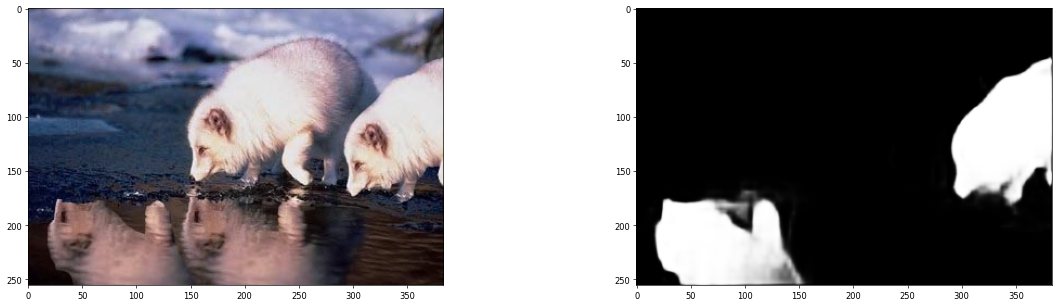

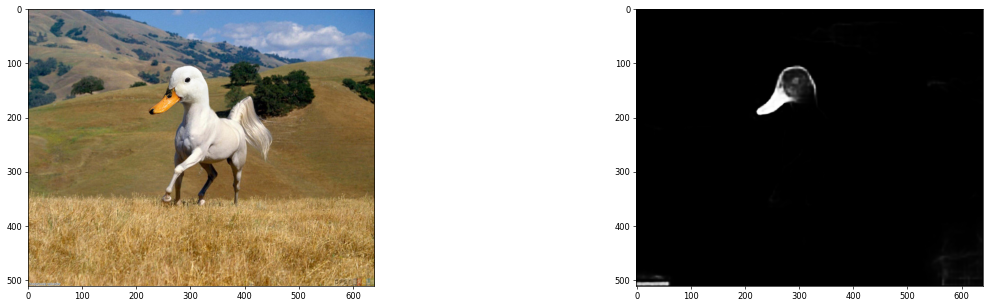

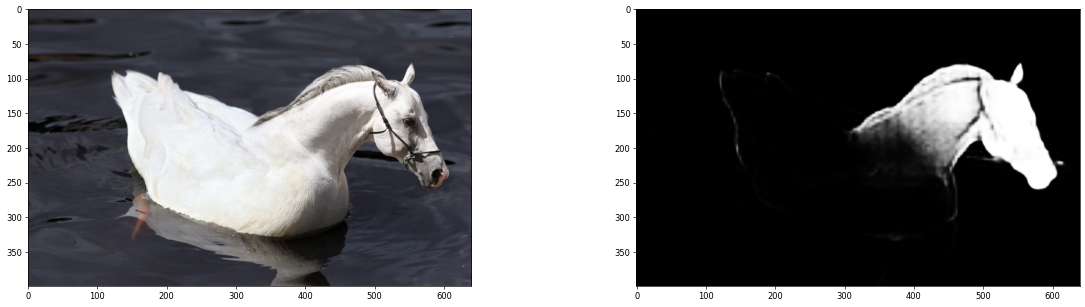

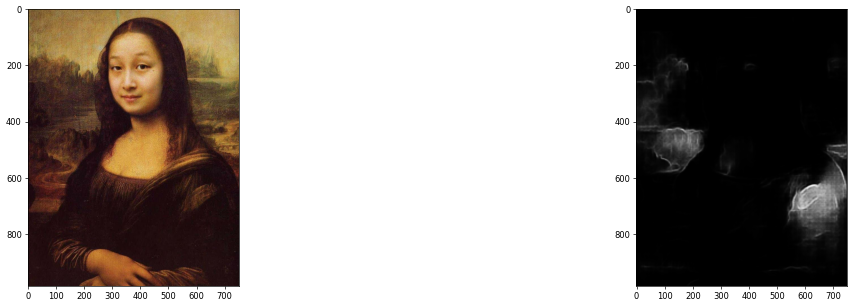

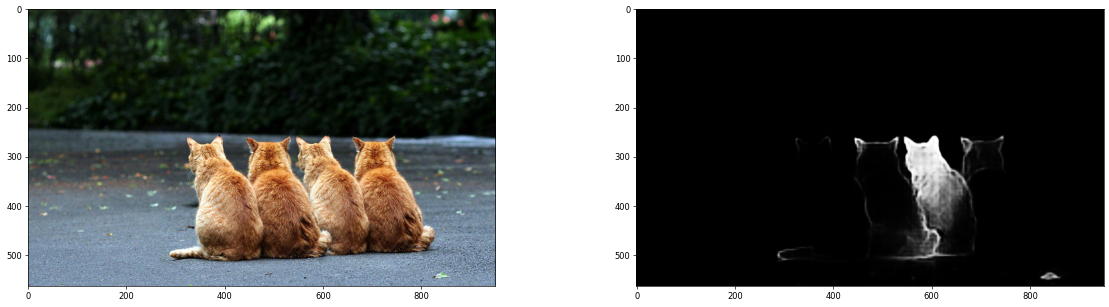

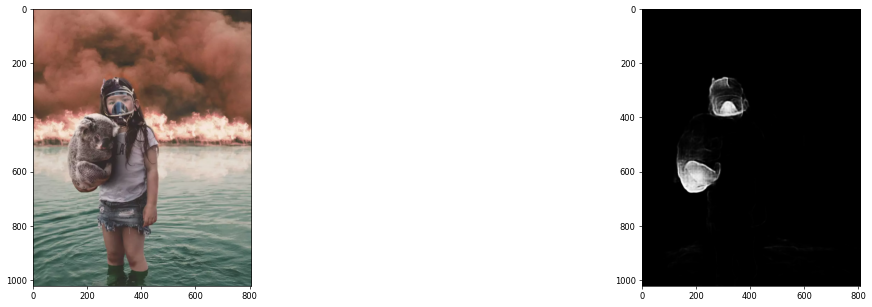

<Figure size 1440x360 with 0 Axes>

In [ ]:
ckpt_path = "./checkpoints/iml-vit_checkpoint_casiav2_20231014.pth"

model.load_state_dict(
  torch.load(ckpt_path),
  strict = True
)
model = model.to(device)

test_image_from_web(urls)

#### **6.2 Test Web Images with CAT-Net (TruFor) protocol checkpoints of IML-ViT.**


<ipython-input-14-2e264339caca>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path),


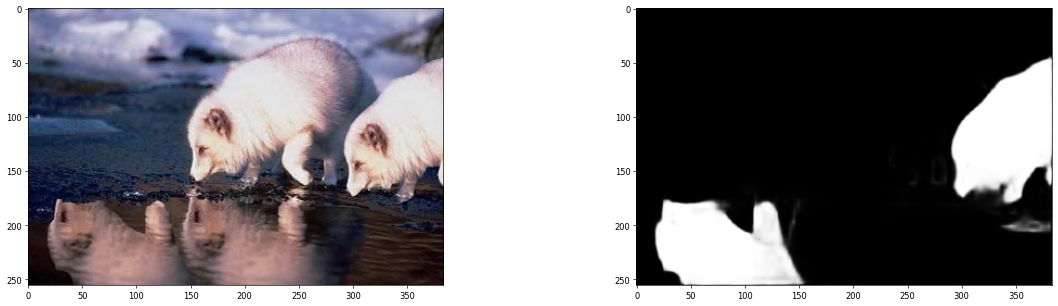

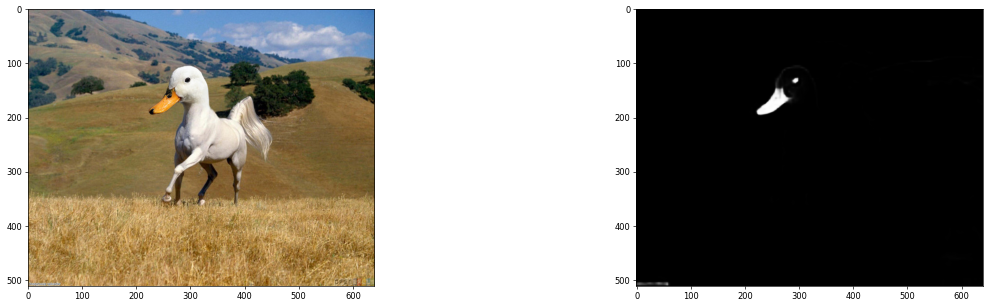

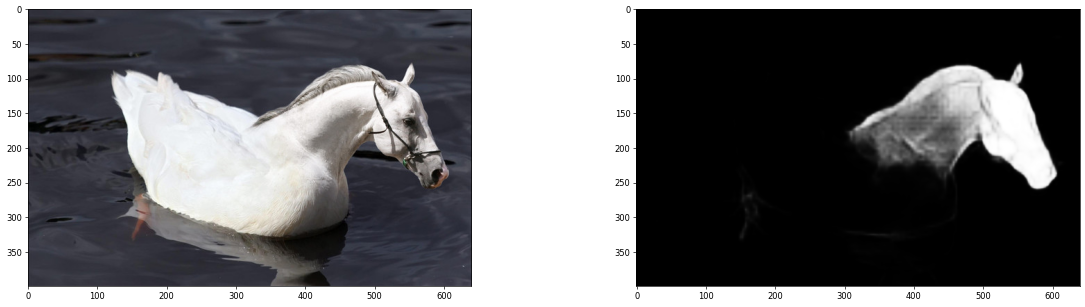

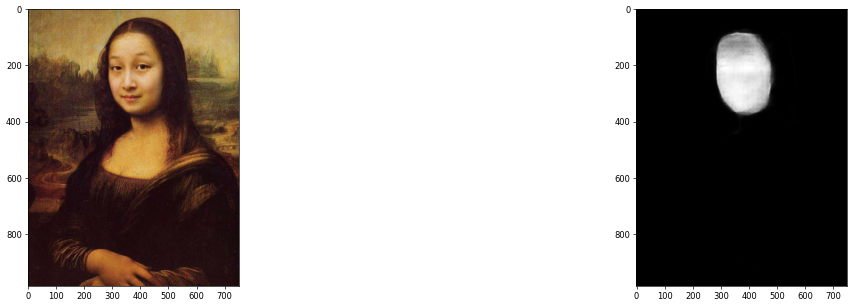

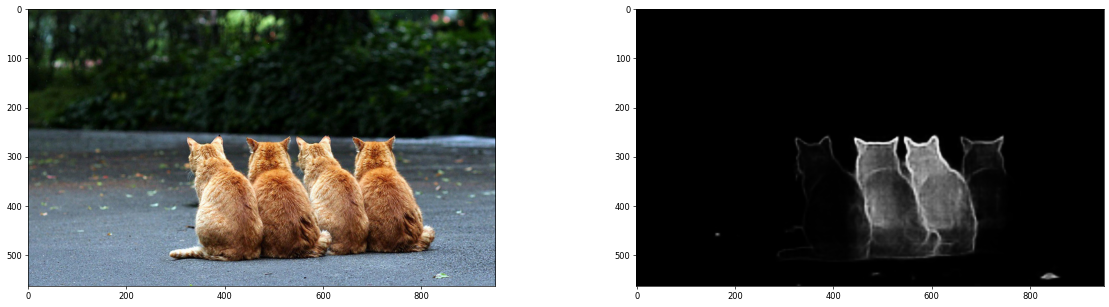

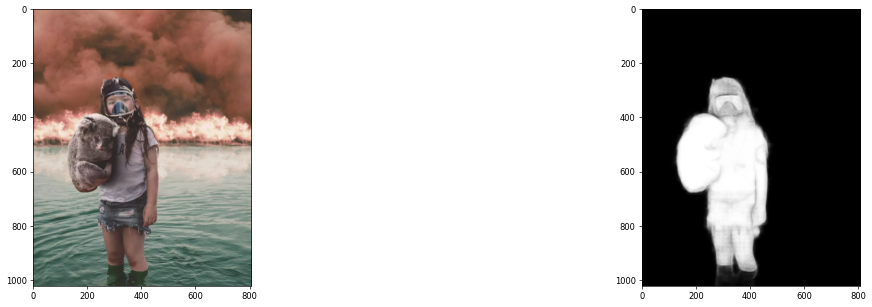

<Figure size 1440x360 with 0 Axes>

In [ ]:
ckpt_path = "./checkpoints/iml-vit_checkpoint_trufor_20231104.pth"

model.load_state_dict(
  torch.load(ckpt_path),
  strict = True
)
model = model.to(device)

test_image_from_web(urls)

**Notes:** Our released checkpoint is trained on the CASIAv2 dataset, which is still limited for various real-world testing images. Hence, IML-ViT may only output some subtle clues for some cases (Anyway, this is still helpful). For better performance, a larger dataset for training is needed in practice. **We will release a large-scale pre-trained model of IML-ViT. Please stay tuned.**